In [1]:
import sys; sys.path.append('../../wwa'); from wwa import *

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/UK_heat/"

# Get shapefile for heatwave threshold

In [67]:
sf = gpd.read_file("sf_claire").set_index("CTYUA23NM")

sf_Dark_Red = sf.loc[["Cambridgeshire", "Bedford", "Central Bedfordshire", "Buckinghamshire", "West Berkshire", "Surrey",\
             "City of London", "Hertfordshire", "Reading", "Windsor and Maidenhead", "Bracknell Forest", "Slough",\
                "Wokingham", "Milton Keynes", "Luton", "Kensington and Chelsea", "Barking and Dagenham",\
                    "Barnet", "Bexley", "Brent", "Bromley", "Camden", "Croydon", "Ealing", "Enfield", "Greenwich",\
                        "Hackney","Hammersmith and Fulham", "Haringey", "Harrow", "Havering", "Hillingdon", "Hounslow",\
                            "Islington", "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham", "Redbridge",\
                                "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets", "Waltham Forest",\
                                    "Wandsworth", "Westminster"]]

sf_hw28 = main_polygon(sf_Dark_Red.dissolve())
sf_hw28.to_file("sf_hw28")

# Daily time series

In [100]:
sf_hw28 = gpd.read_file("sf_hw28").to_crs("EPSG:4326")

In [8]:
haduk = xr.open_dataset(fpath+"tasmax_hadukgrid_12km_day_193105-202408.nc").tasmax
rm_haduk = regionmask.mask_geopandas(sf_hw28, haduk.longitude, haduk.latitude)
haduk_hw28 = haduk.where(~np.isnan(rm_haduk), drop = True).mean(["projection_x_coordinate", "projection_y_coordinate"])

haduk_hw28.to_netcdf(fpath+"tasmax-hw28_hadukgrid_june.nc")

In [5]:
eobs = xr.open_dataset(fpath+"tx_0.25deg_reg_v31.0eu_-10-2E_48-60N_-999-lastyear.nc").tx
rm_eobs = regionmask.mask_geopandas(sf_hw28, eobs.lon, eobs.lat)

eobs_hw28 = eobs.where(~np.isnan(rm_eobs), drop = True).mean(["lon", "lat"])
eobs_hw28.to_netcdf(fpath+"tasmax-hw28_eobs.nc")

In [15]:
era5 = convert_units_to(xr.open_dataset(fpath+"era5_tmax_daily_eu_extended_-10-2E_48-60N_-999-lastyear.nc").tmax, "degC")
rm_era5 = regionmask.mask_geopandas(sf_hw28, era5.lon, era5.lat)

era5_hw28 = era5.where(~np.isnan(rm_era5), drop = True).mean(["lon", "lat"])
era5_hw28.to_netcdf(fpath+"tasmax-hw28_era5.nc")

# Annual time series

In [79]:
ndays = 3
for ds_nm in ["haduk", "eobs", "era5"]:

    ts = eval(ds_nm+"_hw28")
    txnx = ts.rolling(time = ndays).mean().sel(time = ts.time.dt.month.isin([6])).dropna("time", "any").resample(time = "AS-JUN").max()
    txnx.assign_coords(time = txnx.time.dt.year).rename(time = "year").to_dataframe().to_csv(fpath+"tx"+str(ndays)+"x_hw28_"+ds_nm+".csv")

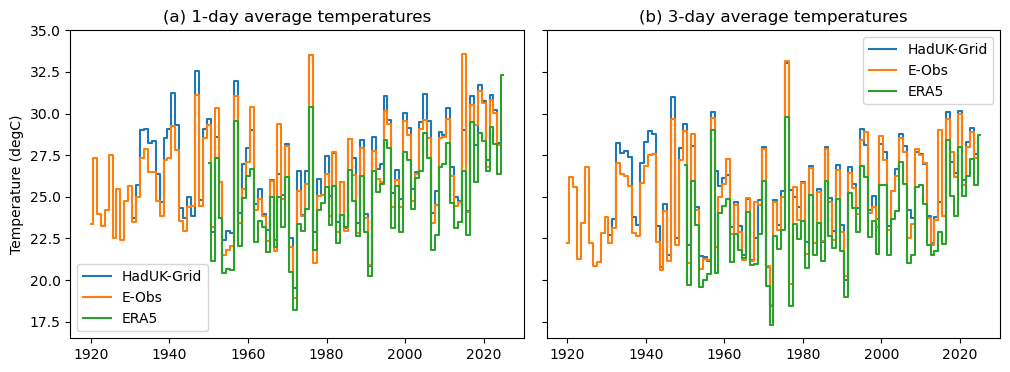

In [35]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), sharey = True, dpi = 100)
plt.subplots_adjust(wspace = 0.05)

[pd.read_csv(fpath+"tx1x_hw28_"+ds_nm+".csv", index_col = "year").plot(ax = axs[0], drawstyle = "steps-mid") for ds_nm in ["haduk", "eobs", "era5"]]
axs[0].legend(["HadUK-Grid", "E-Obs", "ERA5"])
axs[0].set_xlabel("")
axs[0].set_ylabel("Temperature (degC)")
axs[0].set_title("(a) 1-day average temperatures")

[pd.read_csv(fpath+"tx3x_hw28_"+ds_nm+".csv", index_col = "year").plot(ax = axs[1], drawstyle = "steps-mid") for ds_nm in ["haduk", "eobs", "era5"]]
axs[1].legend(["HadUK-Grid", "E-Obs", "ERA5"])
axs[1].set_xlabel("")
axs[1].set_title("(b) 3-day average temperatures")
plt.ylim(16.5,35)

plt.savefig("fig_timeseries_june.png")

In [51]:
haduk_hw28 = xr.open_dataset(fpath+"tasmax-hw28_hadukgrid_june.nc")
eobs_hw28 = xr.open_dataset(fpath+"tasmax-hw28_eobs.nc")
era5_hw28 = xr.open_dataset(fpath+"tasmax-hw28_era5.nc")

ndays = 1
mths = "june"
months = {"jja" : [6,7,8], "june" : [6]}[mths]
months_long = {"jja" : "June-August", "june" : "June"}[mths]

for ds_nm in ["haduk", "eobs", "era5"]:

    ts = eval(ds_nm+"_hw28")
    txnx = ts.rolling(time = ndays).mean().sel(time = ts.time.dt.month.isin(months)).dropna("time", "any").resample(time = "AS-JUN").max()
    z = txnx.assign_coords(time = txnx.time.dt.year).rename(time = "year").to_dataframe()
    z.to_csv(fpath+"tx"+str(ndays)+"x-jja_hw28_"+ds_nm+".csv")
    
    varnm = "tx"+str(ndays)+"x"
    
    csv_fnm = "uk-heat_"+varnm+"-"+mths+"_"+ds_nm
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: "+" "+varnm+" - UK heat, c.barnes22@imperial.ac.uk"
    str2 = "# "+varnm.split("-")[0]+" [degC] - "+months_long+" maxima of "+str(ndays)+"-day mean of daily maximum temperatures over southeastern England at "+csv_fnm+".dat"
    head = "# year "+varnm.split("-")[0]
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    z.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
    clear_output(wait = False)

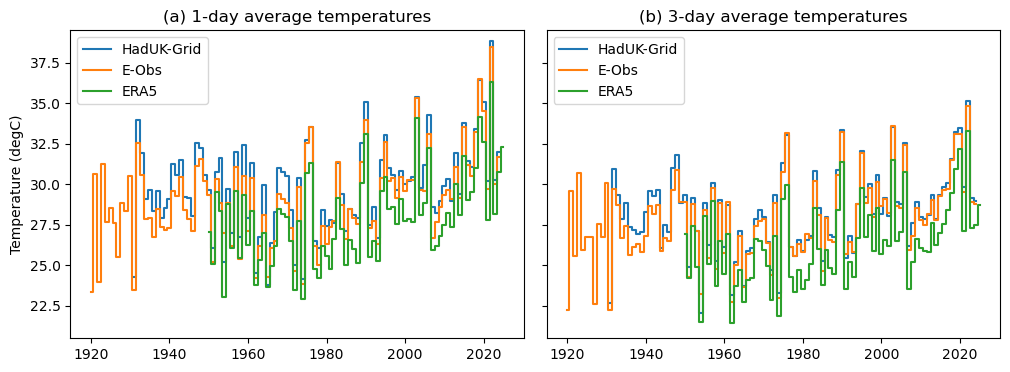

In [38]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), sharey = True, dpi = 100)
plt.subplots_adjust(wspace = 0.05)

[pd.read_csv(fpath+"tx1x-jja_hw28_"+ds_nm+".csv", index_col = "year").plot(ax = axs[0], drawstyle = "steps-mid") for ds_nm in ["haduk", "eobs", "era5"]]
axs[0].legend(["HadUK-Grid", "E-Obs", "ERA5"])
axs[0].set_xlabel("")
axs[0].set_ylabel("Temperature (degC)")
axs[0].set_title("(a) 1-day average temperatures")

[pd.read_csv(fpath+"tx3x-jja_hw28_"+ds_nm+".csv", index_col = "year").plot(ax = axs[1], drawstyle = "steps-mid") for ds_nm in ["haduk", "eobs", "era5"]]
axs[1].legend(["HadUK-Grid", "E-Obs", "ERA5"])
axs[1].set_xlabel("")
axs[1].set_title("(b) 3-day average temperatures")
plt.ylim(20.5,39.5)

plt.savefig("fig_timeseries_jja.png")

# Station data

In [162]:
def dms2dd(x):
    x = x.strip()
    print(x[0])
    degrees, minutes, seconds = x[1:].split(":")
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if x[0] == "-":
        return -dd
    else:
        return dd

In [163]:
df = pd.read_table("ecad-stations.txt", skiprows = 17, sep = ",")
df = df.loc[df.CN == "GB  "]
df["lat"] = [dms2dd(lat) for lat in df['      LAT']]
df["lon"] = [dms2dd(lon) for lon in df['       LON']]
df["stn"] = df['STANAME                                 ']

In [165]:
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
df = df.clip(sf_hw28.to_crs("EPSG:4326"))

In [166]:
df.to_csv("stations-in-region.txt")

## Heathrow

In [69]:
df = pd.read_table("TX_SOUID105838.txt", skiprows = 20, sep = ",", parse_dates = ['    DATE'], index_col = '    DATE')
df = df.rename(columns = {k : v for k, v in zip([' STAID', ' SOUID', '   TX', ' Q_TX'], ["STAID", "SOUID", "tx", "q"])})
df = df.loc[df.tx > -100]
df.tx = df.tx / 10
# df["tx"] = df["tx"]

In [113]:
tx3x = df.rolling(3).mean().loc[df.index.month == 6].resample("AS-JUN").max()
tx3x.index = tx3x.index.year
tx3x[["tx"]].to_csv("tx3x_heathrow.csv")

In [73]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

In [74]:
df_clim = df.loc[slice("1994","2024")]

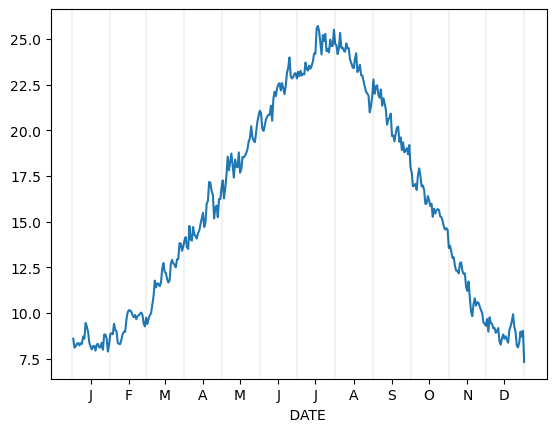

In [78]:
fig, ax = plt.subplots(dpi = 100) 

df_clim["tx"].groupby(df_clim.index.dayofyear).mean().plot(ax = ax)

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]

## CET

In [84]:
cet = pd.read_csv("cet.txt", sep = " +", engine = "python", index_col = "Date", parse_dates = ["Date"])

cet_clim = cet.loc[slice("1994","2024")]

In [87]:
cet_sc = cet_clim.groupby(cet_clim.index.dayofyear).mean()

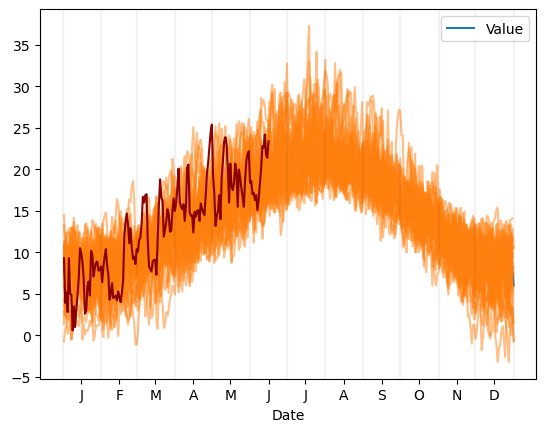

In [92]:
fig, ax = plt.subplots(dpi = 100) 

cet_clim.groupby(cet_clim.index.dayofyear).mean().plot(ax = ax)

for y in range(1994,2024):
    ts_y = cet_clim.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
ax.plot(cet.loc["2025"].index.dayofyear, cet.loc["2025"], color = "darkred")

In [98]:
ts = xr.open_dataset(fpath+"tasmax-hw28_era5.nc").tmax.to_dataframe()

In [ ]:
fig, ax = plt.subplots(dpi = 100) 

for y in range(1994,2024):
    ts_y = cet_clim.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
ax.plot(cet.loc["2025"].index.dayofyear, cet.loc["2025"], color = "darkred")

# Fit to gridded data

In [11]:
# load daily data
da = xr.open_dataset(fpath+"tx_0.25deg_reg_v31.0eu_-10-2E_48-60N_-999-lastyear.nc").tx

# mask land only
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
da = da.where(rm == 0)

# resample to annual
da = da.rolling(time = 3).mean().sel(time = da.time.dt.month.isin([6])).resample(time = "AS").max()

# relabel dates as years
da = da.assign_coords(time = da.time.dt.year).rename(time = "year")

# save the map for easier reconstruction later
da.mean("year").to_netcdf("map-tmplt_tx3x_eobs.nc")

# flatten & convert to data.frame
df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()

# save data.frame as .csv (split into chunks if really large)
ncols = 2500
if df.shape[1] > ncols:
    for i in range(int(np.ceil(df.shape[1] / ncols))):
        df.iloc[:,slice(i*ncols,(i+1)*ncols)].to_csv("tx3x-flattened_eobs_"+str(i+1).rjust(2,"0")+".csv")
else:
    df.to_csv("tx3x-flattened_eobs.csv")

# Maps of gridded trend

In [105]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [106]:
# load target map showing original shape of data
tmplt = xr.open_dataset("map-tmplt_tx3x_eobs.nc").tx

df = pd.read_csv("tx3x-flattened-res_eobs.csv", index_col = 0)

# reconstruct map
res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])

In [107]:
fr = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe()
fr = fr.loc[fr.names == "France"]
rm_fr = regionmask.mask_geopandas(fr, res.lon, res.lat)

res = res.where(np.isnan(rm_fr), drop = True)

In [108]:
# save
res.to_netcdf("gridded-trend_tx3x_eobs.nc")

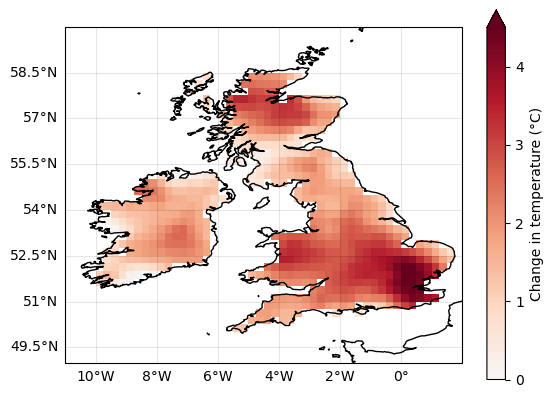

In [111]:
cbar = res.dI_abs_pi.plot(cmap = "RdBu_r", norm = MidpointNormalize(midpoint = 0), vmin = 0, vmax = 4.5, subplot_kws = {"projection" : cartopy.crs.PlateCarree(),"extent" : (-11,2,49,60)},
                       add_colorbar = False)
plt.gca().coastlines()
plt.gca().gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-10,2,2))

plt.colorbar(cbar, ticks = range(0,5), extend = "max", label = "Change in temperature (°C)")
plt.savefig(fpath+"tx3x-june_gridded_eobs.png")

In [110]:
res

<xarray.Dataset>
Dimensions:          (lat: 48, lon: 48)
Coordinates:
  * lon              (lon) float32 -9.875 -9.625 -9.375 ... 1.375 1.625 1.875
  * lat              (lat) float32 48.12 48.38 48.62 48.88 ... 59.38 59.62 59.88
Data variables: (12/14)
    mu0              (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sigma0           (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    alpha_gmst       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    shape            (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    disp             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    event_magnitude  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...               ...
    dI_abs_pi        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dI_rel_pi        (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    PR_2000          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dI_abs_2000      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dI_rel_2000      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    aic              (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:      maximum temperature
    standard_name:  air_temperature
    units:          Celsius

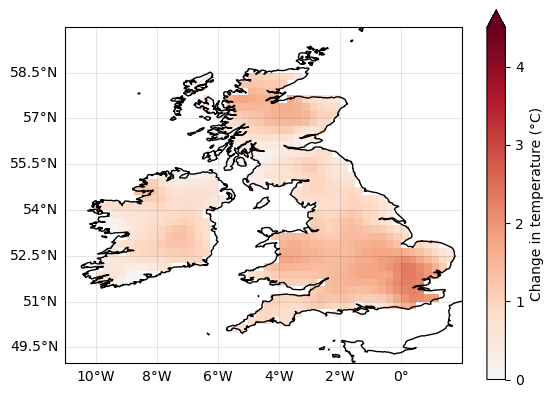

In [112]:
cbar = res.dI_abs_2000.plot(cmap = "RdBu_r", norm = MidpointNormalize(midpoint = 0), vmin = 0, vmax = 4.5, subplot_kws = {"projection" : cartopy.crs.PlateCarree(),"extent" : (-11,2,49,60)},
                       add_colorbar = False)
plt.gca().coastlines()
plt.gca().gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-10,2,2))

plt.colorbar(cbar, ticks = range(0,5), extend = "max", label = "Change in temperature (°C)")
plt.savefig(fpath+"tx3x-june_gridded_eobs.png")